# Anaylsis of fan vibration data 

we first import the  required python libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy, matplotlib
from scipy import pi
from scipy.fftpack import fft
from scipy import fftpack
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

we first define Augmented Dickey–Fuller test as a function to determine whether our signal is stationary or not. By determining this we assure that there is a meaningful information in our data so we can extract it. It doesn't mean that there is no meaningfull information in data when it is non-stationary still there are ways to extract meaningfull data but in our case our signal is stationary later we will examine other cases.



In [2]:
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    if dfoutput["p-value"] < 0.05:
        print("signal is stationary")
    else:
        print("signal is non-stationary")

now we are going to import our data from a csv file named fan.csv and store it as a pandas dataframe.

In [3]:
data = pd.read_csv(r"./data/fan.csv", parse_dates=["Time"], index_col="Time")

In [4]:
data.head()


,telemetry_type,telemetry_value
Time,,
2021-07-09 22:00:00,gyrz,21655.0000
2021-07-09 22:00:00,gyry,5856.0000
2021-07-09 22:00:00,gyrx,549.0000
2021-07-09 22:00:00,gyr_rms,22439.5446
2021-07-09 22:00:00,accz,1126.0000


In [5]:
data.tail()

,telemetry_type,telemetry_value
Time,,
2021-07-09 22:05:59,gyr_rms,14279.9945
2021-07-09 22:05:59,accz,971.0000
2021-07-09 22:05:59,accy,133.0000
2021-07-09 22:05:59,accx,50.0000
2021-07-09 22:05:59,acc_rms,981.3409


now we split our data with respect to "telemetry_type"

In [6]:
gyrz = data[data["telemetry_type"] == "gyrz"]
gyrx = data[data["telemetry_type"] == "gyrx"]
gyry = data[data["telemetry_type"] == "gyry"]
gyrrms = data[data["telemetry_type"] == "gyr_rms"]
accx = data[data["telemetry_type"] == "accx"]
accy = data[data["telemetry_type"] == "accy"]
accz = data[data["telemetry_type"] == "accz"]
accrms = data[data["telemetry_type"] == "acc_rms"]
telemetry_value_accx=accx["telemetry_value"]
telemetry_value_accy=accy["telemetry_value"]
telemetry_value_accz=accz["telemetry_value"]
telemetry_value_accrms=accrms["telemetry_value"]
telemetry_value_gyrx=gyrx["telemetry_value"]
telemetry_value_gyry=gyry["telemetry_value"]
telemetry_value_gyrz=gyrz["telemetry_value"]
telemetry_value_gyrrms=gyrrms["telemetry_value"]

let us use adf(Augmented Dickey–Fuller) test on our gyr rms data in order to understand wheter it is stationary or not

In [7]:
adf_test(gyrrms["telemetry_value"])

Results of Dickey-Fuller Test:
Test Statistic                  -4.602706
p-value                          0.000128
#Lags Used                      14.000000
Number of Observations Used    344.000000
Critical Value (1%)             -3.449503
Critical Value (5%)             -2.869979
Critical Value (10%)            -2.571266
dtype: float64
signal is stationary


since test statistic is less than all of critical values and p-value is less than 0.05 our data is stationary as indiated above

now in order to determine data's periodicity we use acf (auto correlation function), first meaningfull peak will give us its period which is 7 in our case

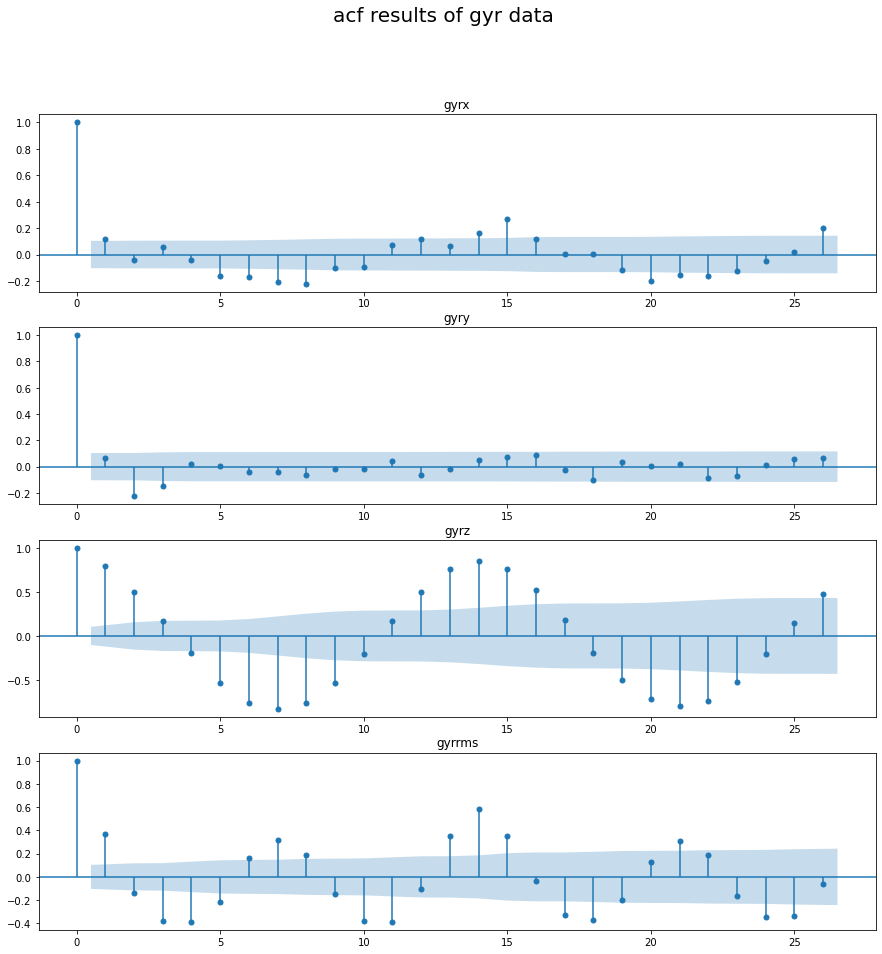

In [8]:
fig, axs = plt.subplots(4)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.suptitle('acf results of gyr data',size=20)
plot_acf(telemetry_value_gyrx, ax=axs[0], title="gyrx")
plot_acf(telemetry_value_gyry, ax=axs[1], title="gyry")
plot_acf(telemetry_value_gyrz, ax=axs[2], title="gyrz")
plot_acf(telemetry_value_gyrrms, ax=axs[3], title="gyrrms")
print()

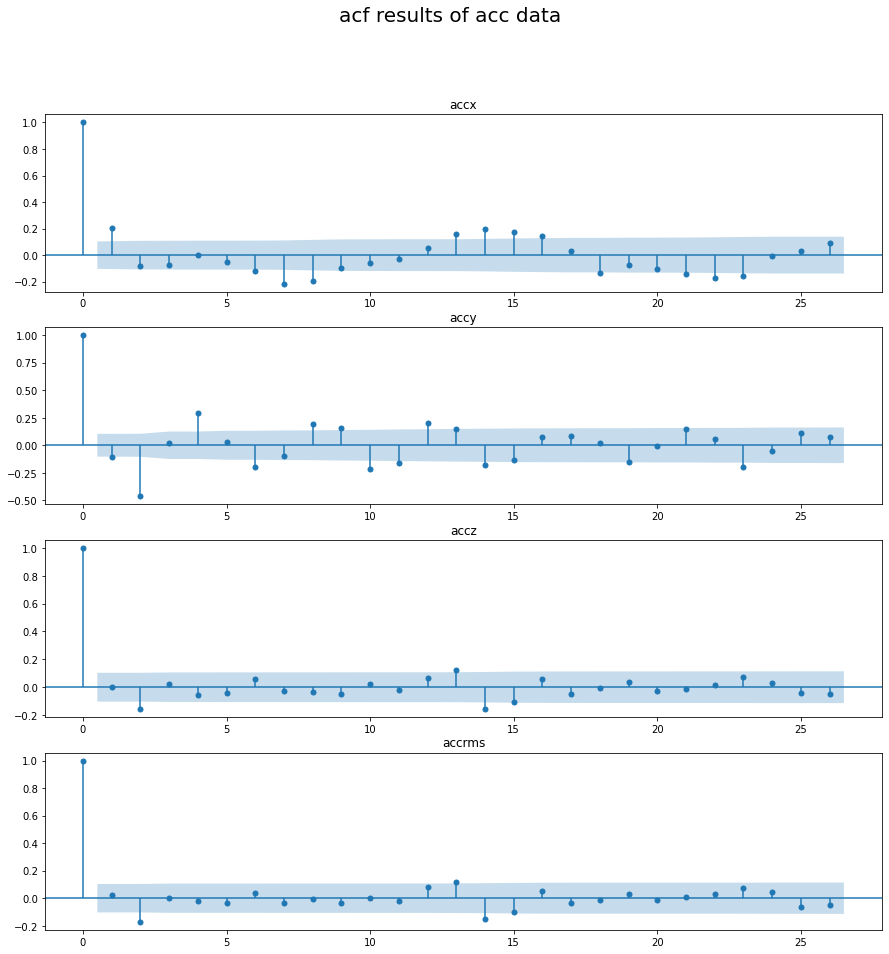

In [9]:
fig, axs = plt.subplots(4)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.suptitle('acf results of acc data',size=20)
plot_acf(telemetry_value_accx, ax=axs[0], title="accx")
plot_acf(telemetry_value_accy, ax=axs[1], title="accy")
plot_acf(telemetry_value_accz, ax=axs[2], title="accz")
plot_acf(telemetry_value_accrms, ax=axs[3], title="accrms")
print()

As we looked at the upper figures we can see that gyro data is crossing confidence area more times (blue colored area) which means there is a sequence in our data and it is more distinctive in gyr. Since gyr data is more distintcive, we are going to use gyr data. Also, since we have no information about the XDK orientation it will be more suitable to use combination of all components. For this particular case, we used rms value.

In this section we are going to decompose our data as seasonal trend and residual parts
seasonal: desired meaningfull data which is 

first plot original data

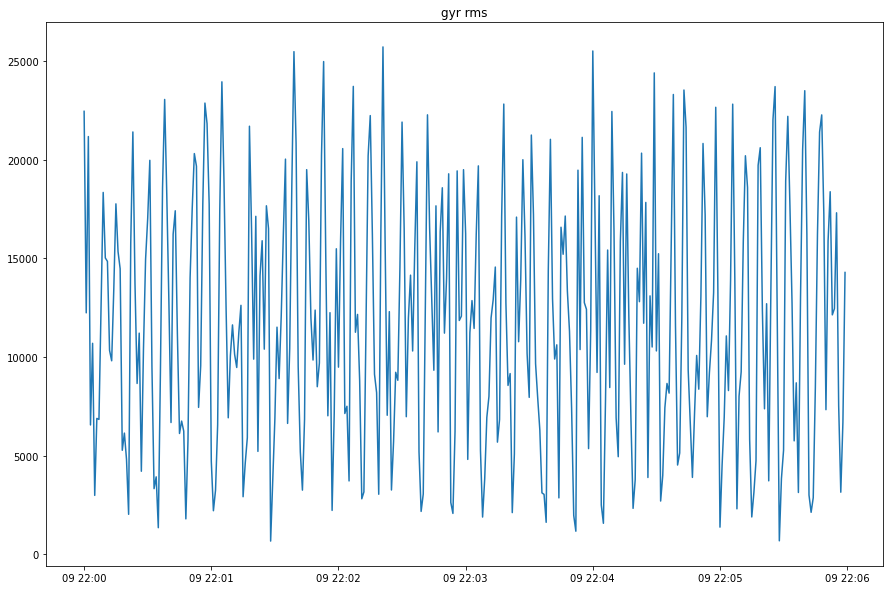

In [10]:
freq = 7

gyrrms_seasonal_decompose = seasonal_decompose(telemetry_value_gyrrms, period=freq)
gyrrms_seasonal = gyrrms_seasonal_decompose.seasonal
gyrrms_trend = gyrrms_seasonal_decompose.trend
gyrrms_resid = gyrrms_seasonal_decompose.resid

iter = 3
seasonals = np.zeros((iter + 1, len(gyrrms_trend)))
seasonals[0, :] = gyrrms_seasonal.to_numpy()
f=plt.figure()
f.set_figheight(10)
f.set_figwidth(15)
plt.title("gyr rms")
plt.plot(telemetry_value_gyrrms)




In order to extract meaningfull data, we decompose our data several times.The main motivation behind that is extracting higher harmonic terms from data. You can see each harmonic terms below.

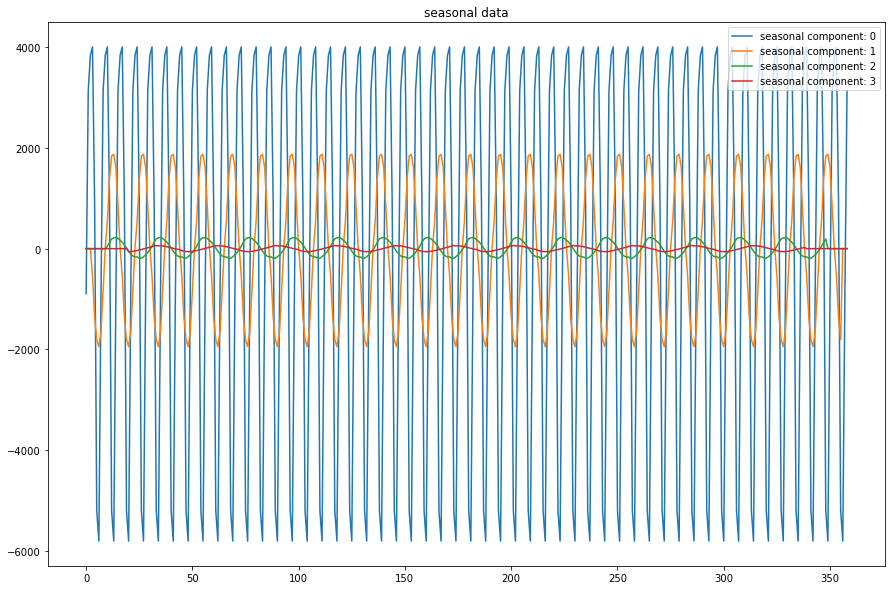

In [11]:
f=plt.figure()
f.set_figheight(10)
f.set_figwidth(15)
plt.title("seasonal data")
plt.plot(seasonals[0], label="seasonal component: 0")
number_of_dropped_na = 0
for i in range(iter):
    number_of_dropped_na += gyrrms_trend.isna().sum() // 2
    gyrrms_seasonal_decompose = seasonal_decompose(gyrrms_trend.dropna(), period=(i + 2) * freq)
    gyrrms_seasonal = gyrrms_seasonal_decompose.seasonal
    gyrrms_trend = gyrrms_seasonal_decompose.trend
    gyrrms_resid = gyrrms_seasonal_decompose.resid
    seasonals[i + 1, number_of_dropped_na:len(gyrrms) - number_of_dropped_na] = gyrrms_seasonal.to_numpy()
    plt.plot(seasonals[i + 1, :], label=f"seasonal component: {i + 1}")

plt.legend()


Finally we plot extracted trend and seasonanal data below.

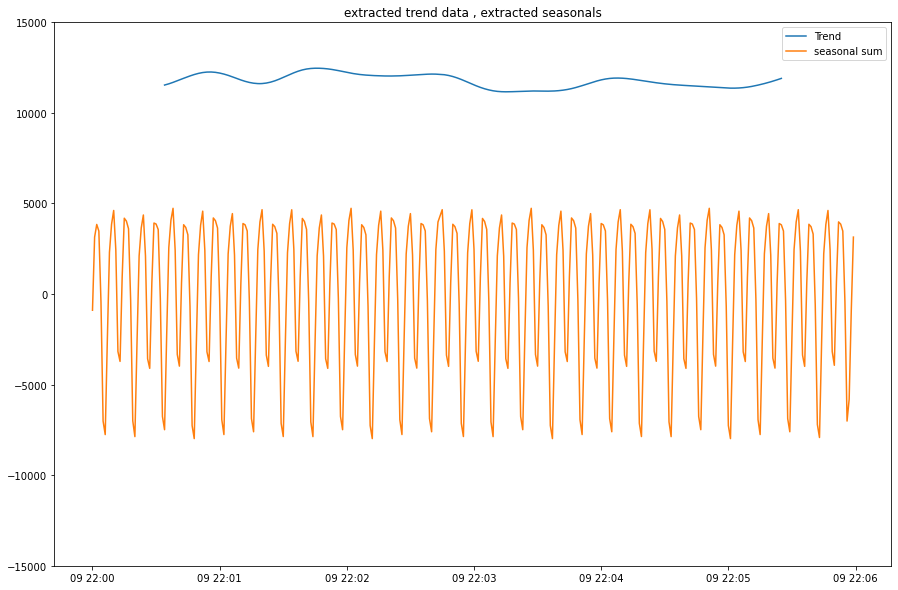

In [12]:
f=plt.figure()
f.set_figheight(10)
f.set_figwidth(15)
plt.title("extracted trend data , extracted seasonals")
plt.plot(gyrrms_trend, label="Trend")
plt.ylim(-15000, 15000)
plt.plot(gyrrms.index, seasonals.sum(axis=0), label="seasonal sum")
plt.legend()
